# NLP Shared Task 2021

## Native Language Identification
Pauline Claes

## 1. Loading modules

In [18]:
import pandas as pd
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.compose import make_column_transformer
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction import DictVectorizer

import nltk
from nltk.tokenize import word_tokenize
nltk__word_tokenizer = word_tokenize
nltk.download("punkt")
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English
from nltk.corpus import stopwords
stop_words_list = set(stopwords.words("english"))


np.random.seed(1)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulineclaes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Preprocessing of the train data set

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.Language.value_counts()

TUR    1000
KOR    1000
JPN    1000
ARA    1000
FRA    1000
TEL    1000
ITA    1000
SPA    1000
HIN    1000
DEU    1000
ZHO    1000
Name: Language, dtype: int64

In [4]:
df.head()

,Filename,text,Language,Proficiency
0,88.txt,Some people might think that traveling in a gr...,KOR,high
1,278.txt,IThe importance and popularity of travelling i...,DEU,medium
2,348.txt,"It is an important decision, how to plan your ...",TUR,high
3,666.txt,Some people believe that young people can enjo...,ZHO,medium
4,733.txt,Travelling is usually considered as good recr...,TEL,medium


In [8]:
def pos_tag(doc):
    return " ".join([token.tag_ for token in nlp(doc)])

def lemmatizer(doc):
    return " ".join([token.lemma_ for token in nlp(doc)])

def stop_words(doc):
    return " ".join([w for w in doc.lower().split() if w in stop_words_list])

In [10]:
# adding pos_tag column
df["pos_tags"] = df.text.apply(pos_tag)

In [7]:
# adding lemmatized text column
df["lemma_text"] = df.text.apply(lemmatizer)

In [8]:
# adding column with stop_words (function words)
df["stop_words"] = df.text.apply(stop_words)

In [9]:
# adding column with text length in number of words
df["n_words"] = df["text"].str.split().str.len()

In [10]:
# adding column with text length in number of sentences
df["n_sentences"] = [text.count(".") for text in df["text"]]

In [11]:
# adding column with text length in number of characters
df["doc_length"] = df.text.apply(len)

In [12]:
# saving preprocessed DataFrame to CSV, to not have to run it again 
# every time. This df will be read in again, and we will move forward
# with this dataframe.
# df.to_csv("train_preprocessed.csv", index=False)

In [5]:
df = pd.read_csv("train_preprocessed.csv")

In [6]:
df.head(5)

,Filename,text,Language,Proficiency,pos_tags,lemma_text,n_words,n_sentences,doc_length,stop_words
0,88.txt,Some people might think that traveling in a gr...,KOR,high,DT NNS MD VB IN VBG IN DT NN VBN IN DT NN NN V...,some people may think that travel in a group l...,384,16,1940,some that in a by a is a a has its and does no...
1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,"IN NN CC NN IN VBG VBZ RB VBG , _SP NN VBZ JJ ...",ithe importance and popularity of travel be st...,321,13,1645,and of is is in to other and but the how to do...
2,348.txt,"It is an important decision, how to plan your ...",TUR,high,"PRP VBZ DT JJ NN , WRB TO VB PRP$ NN . DT NNS ...","-PRON- be an important decision , how to plan ...",360,15,2022,it is an how to your some to a of and their so...
3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DT NNS VBP IN JJ NNS MD VB NN JJR IN JJR NN VB...,some people believe that young people can enjo...,347,26,1891,some that can more than from my of the is the ...
4,733.txt,Travelling is usually considered as good recr...,TEL,medium,"NNP VBZ _SP RB VBN IN JJ NN _SP IN JJ NNS , IN...",Travelling be usually consider as good recre...,349,13,1862,is as by as for and it is to have some and a w...


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     11000 non-null  object
 1   text         11000 non-null  object
 2   Language     11000 non-null  object
 3   Proficiency  11000 non-null  object
 4   pos_tags     11000 non-null  object
 5   lemma_text   11000 non-null  object
 6   n_words      11000 non-null  int64 
 7   n_sentences  11000 non-null  int64 
 8   doc_length   11000 non-null  int64 
 9   stop_words   11000 non-null  object
dtypes: int64(3), object(7)
memory usage: 859.5+ KB


In [34]:
df.describe()

,n_words,n_sentences,doc_length
count,11000.000000,11000.000000,11000.000000
mean,315.093182,16.100909,1787.637182
std,77.407150,5.716632,517.057569
min,2.000000,0.000000,9.000000
25%,278.000000,12.000000,1567.000000
50%,315.000000,16.000000,1784.000000
75%,355.000000,20.000000,2017.000000
max,799.000000,74.000000,29870.000000


In [50]:
df.Language.value_counts()

HIN    1000
SPA    1000
FRA    1000
JPN    1000
TUR    1000
DEU    1000
KOR    1000
ARA    1000
ITA    1000
ZHO    1000
TEL    1000
Name: Language, dtype: int64

In [36]:
X = df.text.values
y = df.Language.values

In [37]:
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y, 
                                                  test_size=0.1,
                                                  random_state=1,
                                                  shuffle=True,
                                                  stratify=y)

## 3. Baselines

### 3.1. Dummy Classifier

In [39]:
from sklearn.dummy import DummyClassifier

#### 3.1.1. Dummy Classifier with CountVectorizer

In [40]:
cvect = CountVectorizer()
dummy_clf = DummyClassifier(strategy="stratified", random_state=1)

In [41]:
X_train_cvect = cvect.fit_transform(X_train)
X_dev_cvect = cvect.transform(X_dev)

In [43]:
dummy_clf.fit(X_train_cvect, y_train)

DummyClassifier(random_state=1, strategy='stratified')

In [44]:
y_pred_dummy = dummy_clf.predict(X_dev_cvect)

In [45]:
print(accuracy_score(y_dev, y_pred_dummy))

0.08363636363636363


In [46]:
print(classification_report(y_dev, y_pred_dummy))

              precision    recall  f1-score   support

         ARA       0.06      0.05      0.05       100
         DEU       0.08      0.09      0.08       100
         FRA       0.09      0.09      0.09       100
         HIN       0.07      0.08      0.08       100
         ITA       0.06      0.05      0.06       100
         JPN       0.09      0.09      0.09       100
         KOR       0.08      0.08      0.08       100
         SPA       0.07      0.07      0.07       100
         TEL       0.14      0.17      0.16       100
         TUR       0.11      0.12      0.12       100
         ZHO       0.03      0.03      0.03       100

    accuracy                           0.08      1100
   macro avg       0.08      0.08      0.08      1100
weighted avg       0.08      0.08      0.08      1100



#### 3.1.2. Dummy Classifier with TfidfVectorizer

In [50]:
tfidf = TfidfVectorizer()
dummy_clf = DummyClassifier(strategy="stratified", random_state=1)

In [51]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_dev_tfidf = tfidf.transform(X_dev)

In [52]:
dummy_clf.fit(X_train_tfidf, y_train)

DummyClassifier(random_state=1, strategy='stratified')

In [53]:
y_pred_dummy = dummy_clf.predict(X_dev_tfidf)

In [54]:
print(accuracy_score(y_dev, y_pred_dummy))

0.08363636363636363


In [55]:
print(classification_report(y_dev, y_pred_dummy))

              precision    recall  f1-score   support

         ARA       0.06      0.05      0.05       100
         DEU       0.08      0.09      0.08       100
         FRA       0.09      0.09      0.09       100
         HIN       0.07      0.08      0.08       100
         ITA       0.06      0.05      0.06       100
         JPN       0.09      0.09      0.09       100
         KOR       0.08      0.08      0.08       100
         SPA       0.07      0.07      0.07       100
         TEL       0.14      0.17      0.16       100
         TUR       0.11      0.12      0.12       100
         ZHO       0.03      0.03      0.03       100

    accuracy                           0.08      1100
   macro avg       0.08      0.08      0.08      1100
weighted avg       0.08      0.08      0.08      1100



### 3.2. Support Vector Machine

#### 3.2.1. SVM with CountVectorizer

In [57]:
svm = SVC()

In [58]:
svm.fit(X_train_cvect, y_train)

SVC()

In [59]:
y_pred_svm = svm.predict(X_dev_cvect)

In [60]:
print(accuracy_score(y_dev, y_pred_svm))

0.6036363636363636


In [61]:
print(classification_report(y_dev, y_pred_svm))

              precision    recall  f1-score   support

         ARA       0.55      0.55      0.55       100
         DEU       0.76      0.72      0.74       100
         FRA       0.60      0.61      0.60       100
         HIN       0.56      0.58      0.57       100
         ITA       0.66      0.66      0.66       100
         JPN       0.51      0.60      0.55       100
         KOR       0.59      0.52      0.55       100
         SPA       0.52      0.54      0.53       100
         TEL       0.64      0.68      0.66       100
         TUR       0.68      0.58      0.63       100
         ZHO       0.61      0.60      0.60       100

    accuracy                           0.60      1100
   macro avg       0.61      0.60      0.60      1100
weighted avg       0.61      0.60      0.60      1100



#### 3.2.2. SVM with TfidfVectorizer

In [63]:
svm = SVC()

In [64]:
svm.fit(X_train_tfidf, y_train)

SVC()

In [65]:
y_pred_svm = svm.predict(X_dev_tfidf)

In [66]:
print(accuracy_score(y_dev, y_pred_svm))

0.7227272727272728


In [67]:
print(classification_report(y_dev, y_pred_svm))

              precision    recall  f1-score   support

         ARA       0.70      0.63      0.66       100
         DEU       0.84      0.83      0.83       100
         FRA       0.76      0.73      0.74       100
         HIN       0.59      0.69      0.64       100
         ITA       0.87      0.77      0.81       100
         JPN       0.69      0.73      0.71       100
         KOR       0.71      0.66      0.68       100
         SPA       0.67      0.74      0.70       100
         TEL       0.75      0.70      0.73       100
         TUR       0.79      0.77      0.78       100
         ZHO       0.64      0.70      0.67       100

    accuracy                           0.72      1100
   macro avg       0.73      0.72      0.72      1100
weighted avg       0.73      0.72      0.72      1100



### 3.3. BERT
Please check separate notebook for BERT baseline.

##  4. Pipeline models

### 4.1. Pipe 1. Logistic Regression and TfidfVectorizer

In [71]:
log_reg = LogisticRegression() # default parameters
tfidf = TfidfVectorizer() # default parameters

In [72]:
pipe1 = make_pipeline(tfidf, log_reg, verbose=True)

In [73]:
pipe1.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   2.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=  10.6s


/Users/paulineclaes/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())],
         verbose=True)

In [74]:
y_pred_pipe1 = pipe1.predict(X_dev)

In [75]:
print(accuracy_score(y_dev, y_pred_pipe1))

0.7190909090909091


In [76]:
print(classification_report(y_dev, y_pred_pipe1))

              precision    recall  f1-score   support

         ARA       0.76      0.59      0.66       100
         DEU       0.82      0.85      0.83       100
         FRA       0.77      0.78      0.78       100
         HIN       0.60      0.66      0.63       100
         ITA       0.76      0.77      0.77       100
         JPN       0.67      0.68      0.68       100
         KOR       0.72      0.68      0.70       100
         SPA       0.70      0.67      0.68       100
         TEL       0.70      0.74      0.72       100
         TUR       0.76      0.74      0.75       100
         ZHO       0.68      0.75      0.71       100

    accuracy                           0.72      1100
   macro avg       0.72      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100



#### 4.1.1. Hyperparameter tuning

In [78]:
pipe1_params = [{'tfidfvectorizer__lowercase' : [True, False], 
                 'tfidfvectorizer__max_df' : [0.70, 0.75, 0.80, 0.85, 0.90, 1.0],
                 'tfidfvectorizer__min_df' : [0.001, 0.01, 0.1],
                 'tfidfvectorizer__ngram_range' : [(1,1), (1,2), (1,3), (1,4)],
                 'tfidfvectorizer__norm' : ['l1', 'l2'],
                 'tfidfvectorizer__tokenizer' : [nltk__word_tokenizer],
                 'logisticregression__C' : [0.01, 0.1, 1.0, 10.0],
                 'logisticregression__max_iter': [1000, 2500, 5000],
                 'logisticregression__multi_class' : ['ovr', 'multinomial']}]

rs_pipe1 = RandomizedSearchCV(estimator = pipe1,
                              param_distributions = pipe1_params, 
                              n_iter = 15, 
                              scoring = 'accuracy', 
                             refit=True, 
                             cv=10, 
                             verbose=1,
                              n_jobs=-1)

In [79]:
rs_pipe1.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  17.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.6s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression())],
                                      verbose=True),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'logisticregression__C': [0.01, 0.1,
                                                                   1.0, 10.0],
                                         'logisticregression__max_iter': [1000,
                                                                          2500,
                                                                          5000],
                                         'logisticregression__multi_class': ['ovr',
                                                                             'multinomial'],
                                    

In [80]:
rs_pipe1_best = rs_pipe1.best_estimator_

In [81]:
print(rs_pipe1.best_params_)

{'tfidfvectorizer__tokenizer': <function word_tokenize at 0x7fd5714a2160>, 'tfidfvectorizer__norm': 'l2', 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__min_df': 0.001, 'tfidfvectorizer__max_df': 0.8, 'tfidfvectorizer__lowercase': False, 'logisticregression__multi_class': 'ovr', 'logisticregression__max_iter': 2500, 'logisticregression__C': 1.0}


### 4.2. Pipe 2. Stochastic Gradient Descent Classifier and TfidfVectorizer

In [82]:
sgd = SGDClassifier() # default parameters
tfidf = TfidfVectorizer() # default parameters

In [83]:
pipe2 = make_pipeline(tfidf, sgd, verbose=True)

In [84]:
pipe2.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   1.7s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   0.6s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('sgdclassifier', SGDClassifier())],
         verbose=True)

In [85]:
y_pred_pipe2 = pipe2.predict(X_dev)

In [86]:
print(accuracy_score(y_dev, y_pred_pipe2))

0.7554545454545455


In [87]:
print(classification_report(y_dev, y_pred_pipe2))

              precision    recall  f1-score   support

         ARA       0.76      0.63      0.69       100
         DEU       0.82      0.89      0.86       100
         FRA       0.79      0.81      0.80       100
         HIN       0.65      0.59      0.62       100
         ITA       0.84      0.87      0.86       100
         JPN       0.74      0.74      0.74       100
         KOR       0.67      0.68      0.68       100
         SPA       0.74      0.66      0.70       100
         TEL       0.71      0.82      0.76       100
         TUR       0.75      0.80      0.78       100
         ZHO       0.81      0.82      0.82       100

    accuracy                           0.76      1100
   macro avg       0.75      0.76      0.75      1100
weighted avg       0.75      0.76      0.75      1100



#### 4.2.1. Hyperparameter tuning

In [89]:
pipe2_params = [{'tfidfvectorizer__lowercase' : [True, False], 
                 'tfidfvectorizer__max_df' : [0.70, 0.75, 0.80, 0.85, 0.90, 1.0],
                 'tfidfvectorizer__min_df' : [0.001, 0.01, 0.1],
                 'tfidfvectorizer__ngram_range' : [(1,1), (1,2), (1,3), (1,4)],
                 'tfidfvectorizer__norm' : ['l1', 'l2'],
                 'tfidfvectorizer__tokenizer' : [nltk__word_tokenizer],
                 'sgdclassifier__loss' : ['hinge', 'log', 'squared_hinge'],
                 'sgdclassifier__penalty' : ['l2', 'l1', 'elasticnet'],
                 'sgdclassifier__alpha' : [1e-4, 1e-3, 0.01, 0.1, 1.0],
                 'sgdclassifier__max_iter': [1000, 2500, 5000]}] 

rs_pipe2 = RandomizedSearchCV(estimator = pipe2,
                              param_distributions = pipe2_params, 
                              n_iter = 15, 
                              scoring = 'accuracy', 
                              refit=True, 
                              cv=10, 
                              verbose=1, 
                              n_jobs=-1)

In [90]:
rs_pipe2.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  31.6s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.5s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('sgdclassifier',
                                              SGDClassifier())],
                                      verbose=True),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'sgdclassifier__alpha': [0.0001, 0.001,
                                                                  0.01, 0.1,
                                                                  1.0],
                                         'sgdclassifier__loss': ['hinge', 'log',
                                                                 'squared_hinge'],
                                         'sgdclassifier__max_iter': [1000, 2500,
                                                                     5000],
                                         'sgdclassifier__penalt...',
 

In [91]:
rs_pipe2_best = rs_pipe2.best_estimator_

In [92]:
print(rs_pipe2.best_params_)

{'tfidfvectorizer__tokenizer': <function word_tokenize at 0x7fd5714a2160>, 'tfidfvectorizer__norm': 'l2', 'tfidfvectorizer__ngram_range': (1, 4), 'tfidfvectorizer__min_df': 0.1, 'tfidfvectorizer__max_df': 1.0, 'tfidfvectorizer__lowercase': True, 'sgdclassifier__penalty': 'l1', 'sgdclassifier__max_iter': 1000, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__alpha': 0.0001}


### 4.3. Pipe 3. LinearSVC and TfidfVectorizer

In [93]:
linear_svc = LinearSVC() # default parameters
tfidf = TfidfVectorizer() # default parameters

In [94]:
pipe3 = make_pipeline(tfidf, linear_svc, verbose=True)

In [95]:
pipe3.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   1.2s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC())],
         verbose=True)

In [96]:
y_pred_pipe3 = pipe3.predict(X_dev)

In [97]:
print(accuracy_score(y_dev, y_pred_pipe3))

0.7636363636363637


In [98]:
print(classification_report(y_dev, y_pred_pipe3))

              precision    recall  f1-score   support

         ARA       0.72      0.64      0.68       100
         DEU       0.87      0.87      0.87       100
         FRA       0.79      0.84      0.81       100
         HIN       0.71      0.68      0.69       100
         ITA       0.88      0.86      0.87       100
         JPN       0.72      0.74      0.73       100
         KOR       0.69      0.69      0.69       100
         SPA       0.77      0.71      0.74       100
         TEL       0.73      0.80      0.76       100
         TUR       0.75      0.78      0.76       100
         ZHO       0.78      0.79      0.79       100

    accuracy                           0.76      1100
   macro avg       0.76      0.76      0.76      1100
weighted avg       0.76      0.76      0.76      1100



#### 4.3.1. Hyperparameter tuning

In [101]:
rs_pipe3_params = [{'tfidfvectorizer__lowercase' : [True, False], 
                     'tfidfvectorizer__max_df' : [0.70, 0.75, 0.80, 0.85, 0.90, 1.0],
                     'tfidfvectorizer__min_df' : [0.001, 0.01, 0.1],
                     'tfidfvectorizer__ngram_range' : [(1,1), (1,2), (1,3), (1,4)],
                     'tfidfvectorizer__norm' : ['l1', 'l2'],
                     'tfidfvectorizer__tokenizer' : [nltk__word_tokenizer],
                     'linearsvc__C' : [0.1, 1.0, 10.0],
                     'linearsvc__max_iter' : [1000, 2500, 5000]}]

rs_pipe3 = RandomizedSearchCV(estimator = pipe3, 
                              param_distributions=rs_pipe3_params, 
                              n_iter = 15, 
                              scoring='accuracy', 
                              refit=True, 
                              cv=10, 
                              verbose=2,
                              random_state=1,
                              n_jobs=-1)

In [102]:
rs_pipe3.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  27.3s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   3.0s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('linearsvc', LinearSVC())],
                                      verbose=True),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'linearsvc__C': [0.1, 1.0, 10.0],
                                         'linearsvc__max_iter': [1000, 2500,
                                                                 5000],
                                         'tfidfvectorizer__lowercase': [True,
                                                                        False],
                                         'tfidfvectorizer__max_df': [0.7, 0.75,
                                                                     0.8, 0.85,
                                                                     0.9, 1.0],
                                         'tfidfvector

In [103]:
rs_pipe3_best = rs_pipe3.best_estimator_

In [104]:
print(rs_pipe3.best_params_)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, max_df=0.8, min_df=0.001,
                                 ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fd5714a2160>)),
                ('linearsvc', LinearSVC())],
         verbose=True)


## 5. Stacked Classifier

### 5.1. Stacked 1. Logistic Regression, Stochastic Gradient Descent, LinearSVC, TfidfVectorizer. 
<u>Input feature:</u> *text* column

In [123]:
from sklearn.ensemble import StackingClassifier

In [110]:
#print(rs_pipe1.best_params_)

In [112]:
#print(rs_pipe2.best_params_)

In [122]:
#print(rs_pipe3.best_params_)

In [116]:
tfidf_log_reg = TfidfVectorizer(tokenizer = nltk__word_tokenizer,
                               norm="l2", 
                               ngram_range=(1,1),
                               min_df = 0.001, 
                               max_df = 0.8, 
                               lowercase=False)
log_reg = LogisticRegression(multi_class="ovr", 
                             max_iter=2500, 
                             C = 1.0,
                             random_state=1)
#####

tfidf_sgd = TfidfVectorizer(tokenizer = nltk__word_tokenizer, 
                            norm="l2", 
                            ngram_range=(1,4), 
                            min_df = 0.1, 
                            max_df = 1.0, 
                            lowercase=True)
sgd = SGDClassifier(penalty = "l1", 
                    max_iter = 1000, 
                    loss = "hinge", 
                    random_state=1)

#####

tfidf_linear_svc = TfidfVectorizer(tokenizer = nltk__word_tokenizer,
                                  norm = "l2", 
                                  ngram_range=(1,3), 
                                  min_df = 0.001, 
                                  max_df = 0.8,
                                  lowercase=False)
linear_svc = LinearSVC(max_iter = 1000, 
                       C = 1.0,
                       random_state=1)

#####

final_logreg = LogisticRegression(multi_class="multinomial",
                                 max_iter=1000)

stacked1 = StackingClassifier(estimators=[('pipe1', make_pipeline(tfidf_log_reg, log_reg, verbose=True)),
                                          ('pipe2', make_pipeline(tfidf_sgd, sgd, verbose=True)),
                                          ('pipe3', make_pipeline(tfidf_linear_svc, linear_svc, verbose=True))],
                              final_estimator=final_logreg,
                              verbose=1)


In [118]:
stacked1.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  18.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.5s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  28.9s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.4s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  23.8s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   3.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  13.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.1s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  12.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.0s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  12.7s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   4.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  13.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.0s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  12.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  23.9s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  22.9s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.3s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  22.9s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.3s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  23.0s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  23.2s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  19.1s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  19.0s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  19.2s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  18.4s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  19.5s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


StackingClassifier(estimators=[('pipe1',
                                Pipeline(steps=[('tfidfvectorizer',
                                                 TfidfVectorizer(lowercase=False,
                                                                 max_df=0.8,
                                                                 min_df=0.001,
                                                                 tokenizer=<function word_tokenize at 0x7fd5714a2160>)),
                                                ('logisticregression',
                                                 LogisticRegression(max_iter=2500,
                                                                    multi_class='ovr',
                                                                    random_state=1))],
                                         verbose=True)),
                               ('pipe2',
                                Pipeline(steps=[('tfidfvectorizer',
                                      

In [119]:
y_pred_stacked1 = stacked1.predict(X_dev)

In [120]:
print(accuracy_score(y_dev, y_pred_stacked1))

0.8290909090909091


In [121]:
print(classification_report(y_dev, y_pred_stacked1))

              precision    recall  f1-score   support

         ARA       0.80      0.77      0.79       100
         DEU       0.95      0.96      0.96       100
         FRA       0.82      0.86      0.84       100
         HIN       0.76      0.78      0.77       100
         ITA       0.89      0.88      0.88       100
         JPN       0.77      0.81      0.79       100
         KOR       0.82      0.72      0.77       100
         SPA       0.83      0.81      0.82       100
         TEL       0.82      0.78      0.80       100
         TUR       0.84      0.86      0.85       100
         ZHO       0.82      0.89      0.86       100

    accuracy                           0.83      1100
   macro avg       0.83      0.83      0.83      1100
weighted avg       0.83      0.83      0.83      1100



### 5.2. Stacked 2. Logistic Regression, Stochastic Gradient Descent Classifier, LinearSVC, TfidfVectorizer <u>(BEST PERFORMING CLASSIFIER)</u>
<u>Input feature:</u> lemmatized text

In [8]:
X_lemma = df.lemma_text.values
y_lemma = df.Language.values

X_train_lemma, X_dev_lemma, y_train_lemma, y_dev_lemma = train_test_split(X_lemma,
                                                  y_lemma, 
                                                  test_size=0.1,
                                                  random_state=1,
                                                  shuffle=True,
                                                  stratify=y_lemma)

In [10]:
tfidf_log_reg = TfidfVectorizer(tokenizer = nltk__word_tokenizer,
                               norm="l2", 
                               ngram_range=(1,1),
                               min_df = 0.001, 
                               max_df = 0.8, 
                               lowercase=False)
log_reg = LogisticRegression(multi_class="ovr", 
                             max_iter=2500, 
                             C = 1.0,
                             random_state=1)
#####

tfidf_sgd = TfidfVectorizer(tokenizer = nltk__word_tokenizer, 
                            norm="l2", 
                            ngram_range=(1,4), 
                            min_df = 0.1, 
                            max_df = 1.0, 
                            lowercase=True)
sgd = SGDClassifier(penalty = "l1", 
                    max_iter = 1000, 
                    loss = "hinge", 
                    alpha = 0.0001,
                    random_state=1)

#####

tfidf_linear_svc = TfidfVectorizer(tokenizer = nltk__word_tokenizer,
                                  norm = "l2", 
                                  ngram_range=(1,3), 
                                  min_df = 0.001, 
                                  max_df = 0.8,
                                  lowercase=False)
linear_svc = LinearSVC(max_iter = 1000, 
                       C = 1.0,
                       random_state=1)

#####

final_logreg = LogisticRegression(multi_class="multinomial",
                                 max_iter=1000)

stacked2 = StackingClassifier(estimators=[('pipe1', make_pipeline(tfidf_log_reg, log_reg, verbose=True)),
                                          ('pipe2', make_pipeline(tfidf_sgd, sgd, verbose=True)),
                                          ('pipe3', make_pipeline(tfidf_linear_svc, linear_svc, verbose=True))],
                              final_estimator=final_logreg,
                              verbose=1)


In [11]:
stacked2.fit(X_train_lemma, y_train_lemma)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  18.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.4s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  33.4s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.8s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  27.0s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  14.3s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   1.8s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  14.7s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.0s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  14.6s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   1.9s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  14.3s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   2.3s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  15.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   1.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  27.2s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.6s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  26.9s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.6s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  26.5s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.6s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  26.4s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.3s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  26.2s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total=   1.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  21.5s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.3s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  20.9s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.4s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  21.3s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  20.7s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.2s
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  21.2s
[Pipeline] ......... (step 2 of 2) Processing linearsvc, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


StackingClassifier(estimators=[('pipe1',
                                Pipeline(steps=[('tfidfvectorizer',
                                                 TfidfVectorizer(lowercase=False,
                                                                 max_df=0.8,
                                                                 min_df=0.001,
                                                                 tokenizer=<function word_tokenize at 0x7fae3987cf70>)),
                                                ('logisticregression',
                                                 LogisticRegression(max_iter=2500,
                                                                    multi_class='ovr',
                                                                    random_state=1))],
                                         verbose=True)),
                               ('pipe2',
                                Pipeline(steps=[('tfidfvectorizer',
                                      

In [12]:
y_pred_stacked2 = stacked2.predict(X_dev_lemma)

In [14]:
print(accuracy_score(y_dev_lemma, y_pred_stacked2))

0.8336363636363636


In [16]:
print(classification_report(y_dev_lemma, y_pred_stacked2))

              precision    recall  f1-score   support

         ARA       0.82      0.79      0.81       100
         DEU       0.90      0.93      0.92       100
         FRA       0.81      0.87      0.84       100
         HIN       0.80      0.77      0.79       100
         ITA       0.89      0.90      0.90       100
         JPN       0.83      0.80      0.82       100
         KOR       0.80      0.77      0.79       100
         SPA       0.84      0.77      0.80       100
         TEL       0.82      0.83      0.83       100
         TUR       0.84      0.86      0.85       100
         ZHO       0.80      0.88      0.84       100

    accuracy                           0.83      1100
   macro avg       0.83      0.83      0.83      1100
weighted avg       0.83      0.83      0.83      1100



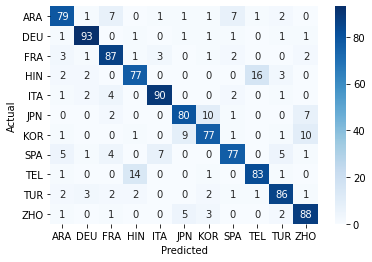

In [19]:
confusion_matrix = pd.crosstab(y_dev_lemma, y_pred_stacked2, rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()


## 6. Combining features

In [5]:
df = pd.read_csv("train_preprocessed.csv")

In [6]:
# creating a development dataframe
dev = df.groupby("Language", group_keys=False).sample(n = 100, random_state=1)
train = df.drop(dev.index)

In [137]:
print(train.shape, dev.shape)

(9900, 10) (1100, 10)


In [138]:
train.Language.value_counts()

ZHO    900
ITA    900
DEU    900
TUR    900
TEL    900
SPA    900
FRA    900
ARA    900
HIN    900
KOR    900
JPN    900
Name: Language, dtype: int64

In [139]:
dev.Language.value_counts()

ZHO    100
KOR    100
TUR    100
SPA    100
JPN    100
ITA    100
FRA    100
DEU    100
TEL    100
ARA    100
HIN    100
Name: Language, dtype: int64

### 6.1. Text, text length in number of words, and character *n*-grams.
- <u>Classifier:</u> Logistic Regression
- <u>Input feature:</u> Text, text length in number of words, and character *n*-grams

In [168]:
X_train = train[["text", "n_words"]]
y_train = train["Language"]

X_dev = dev[["text", "n_words"]]
y_dev = dev["Language"]

In [169]:
tfidf_text = TfidfVectorizer(ngram_range=(1,2),  # article Malmasi et al. (2018)
                               min_df = 0.001, 
                               max_df = 0.8, 
                               lowercase=False)

tfidf_char = TfidfVectorizer(analyzer="char_wb",
                            ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # for numeric feature, with_mean=False to work with sparse vector

preprocessor1 = make_column_transformer(
    (sc, ["n_words"]),
    (tfidf_text, "text"),
    (tfidf_char, "text"),
remainder="passthrough")


log_reg = LogisticRegression(max_iter=1000)

In [170]:
combo1 = make_pipeline(preprocessor1, log_reg, verbose=True)

In [171]:
combo1.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  24.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total= 2.1min


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['n_words']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_df=0.8,
                                                                  min_df=0.001,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(analyzer='cha

In [172]:
y_pred_combo1 = combo1.predict(X_dev)

In [173]:
print(accuracy_score(y_dev, y_pred_combo1))

0.7327272727272728


In [175]:
print(classification_report(y_dev, y_pred_combo1))

              precision    recall  f1-score   support

         ARA       0.71      0.72      0.72       100
         DEU       0.74      0.93      0.83       100
         FRA       0.78      0.77      0.77       100
         HIN       0.63      0.67      0.65       100
         ITA       0.84      0.78      0.81       100
         JPN       0.70      0.68      0.69       100
         KOR       0.65      0.70      0.67       100
         SPA       0.74      0.62      0.67       100
         TEL       0.69      0.76      0.72       100
         TUR       0.83      0.74      0.78       100
         ZHO       0.79      0.69      0.74       100

    accuracy                           0.73      1100
   macro avg       0.74      0.73      0.73      1100
weighted avg       0.74      0.73      0.73      1100



### 6.2. Lemmatized text, function words and character *n*-grams

In [7]:
X_train = train[["lemma_text", "text", "stop_words"]]
y_train = train["Language"]

X_dev = dev[["lemma_text", "text", "stop_words"]]
y_dev = dev["Language"]

In [34]:
tfidf_lemma = TfidfVectorizer(ngram_range=(1,2),# article Malmasi et al. (2018)
                              min_df=0.001,
                              max_df = 0.8,
                               lowercase=False)

tfidf_char = TfidfVectorizer(analyzer="char_wb",
                            ngram_range=(1,3)) # article Malmasi et al. (2018), character uni-, bi- and trigrams

tfidf_stop_words = TfidfVectorizer(ngram_range=(1,2)) # article Malmasi et al. (2018), function word uni- and bigrams.

preprocessor2 = make_column_transformer(
    (tfidf_lemma, "lemma_text"),
    (tfidf_char, "text"),
    (tfidf_stop_words, "stop_words")
)

logreg = LogisticRegression(max_iter=1000, verbose=1, random_state=1)

In [35]:
combo2 = make_pipeline(preprocessor2, logreg, verbose=True)

In [36]:
combo2.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing columntransformer, total=  27.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline]  (step 2 of 2) Processing logisticregression, total= 1.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_df=0.8,
                                                                  min_df=0.001,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'lemma_text'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'text'),
                                     

In [37]:
y_pred_combo2 = combo2.predict(X_dev)

In [40]:
print(accuracy_score(y_dev, y_pred_combo2))

0.7045454545454546


In [39]:
print(classification_report(y_dev, y_pred_combo2))

              precision    recall  f1-score   support

         ARA       0.64      0.66      0.65       100
         DEU       0.75      0.89      0.82       100
         FRA       0.71      0.72      0.71       100
         HIN       0.66      0.73      0.70       100
         ITA       0.78      0.76      0.77       100
         JPN       0.71      0.66      0.68       100
         KOR       0.61      0.67      0.64       100
         SPA       0.75      0.63      0.68       100
         TEL       0.72      0.76      0.74       100
         TUR       0.77      0.61      0.68       100
         ZHO       0.66      0.66      0.66       100

    accuracy                           0.70      1100
   macro avg       0.71      0.70      0.70      1100
weighted avg       0.71      0.70      0.70      1100



### 6.3. Lemmatized text, text length in number of words, and character *n*-grams
- <u>Classifier:</u> best stacked classifier (obtaining 83%), with the best parameters for each of the classifiers (obtained during RandomizedSearchCV)
    - Logistic Regression
    - SGDClassifier
    - LinearSVC
- <u>Input features:</u> lemmatized text, text length in number of words, and character *n*-grams

In [41]:
X_train = train[["text", "n_words", "lemma_text"]]
y_train = train["Language"]

X_dev = dev[["text", "n_words", "lemma_text"]]
y_dev = dev["Language"]

In [42]:
tfidf_text = TfidfVectorizer(ngram_range=(1,2),  
                               min_df = 0.001, 
                               max_df = 0.8, 
                               lowercase=False)

tfidf_lemma = TfidfVectorizer(ngram_range=(1,2),  
                              min_df = 0.001,
                              max_df = 0.8,
                              lowercase=False)

tfidf_char = TfidfVectorizer(analyzer="char_wb",
                            ngram_range=(1,3))

sc = StandardScaler(with_mean=False) # for numeric feature, with_mean=False to work with sparse vector

preprocessor = make_column_transformer(
    (sc, ["n_words"]),
    (tfidf_text, "text"),
    (tfidf_char, "text"),
    (tfidf_lemma, "lemma_text"),
remainder="passthrough")

In [44]:
log_reg = LogisticRegression(multi_class="ovr", 
                             max_iter=2500, 
                             C = 1.0,
                             random_state=1, verbose=1)

linear_svc = LinearSVC(max_iter = 1000, 
                       C = 1.0,
                       random_state=1, verbose=1)

sgd = SGDClassifier(penalty = "l1", 
                    max_iter = 1000, 
                    loss = "hinge", 
                    alpha = 0.0001,
                    random_state=1, verbose=1)


final_logreg = LogisticRegression(multi_class="multinomial",
                                 max_iter=1000)

stacked = StackingClassifier(estimators=[('log_reg', log_reg),
                                          ('sgd', sgd),
                                          ('linear_svc', linear_svc)],
                              final_estimator=final_logreg,
                              verbose=1)



In [45]:
combo_stacked = make_pipeline(preprocessor, stacked, verbose=True)

In [1]:
##### This cell was commented after predicting, as it generated an enormously verbose output, which is very 
# unpractical for the Github Repo.

#combo_stacked.fit(X_train, y_train)


In [47]:
y_pred_combo_stacked = combo_stacked.predict(X_dev)

In [48]:
print(accuracy_score(y_dev, y_pred_combo_stacked))

0.8145454545454546


In [49]:
print(classification_report(y_dev, y_pred_combo_stacked))

              precision    recall  f1-score   support

         ARA       0.79      0.83      0.81       100
         DEU       0.88      0.92      0.90       100
         FRA       0.79      0.81      0.80       100
         HIN       0.76      0.78      0.77       100
         ITA       0.83      0.91      0.87       100
         JPN       0.75      0.73      0.74       100
         KOR       0.71      0.76      0.73       100
         SPA       0.81      0.79      0.80       100
         TEL       0.81      0.80      0.80       100
         TUR       0.91      0.84      0.87       100
         ZHO       0.92      0.79      0.85       100

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

